In [1]:
import pandas as pd
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from vmax_cal import cal_v_vmax_mp

# Data

## Firefly Catalog

In [2]:
#   Data from MPA-JHU DR7
##  Info for gals
mpa_gal_info = Table.read('/Users/abry/data/MPA_JHU/DR7/gal_info_dr7.fit.gz')
mpa_gal_info_df = mpa_gal_info[['PLATEID', 'MJD', 'FIBERID','Z','Z_WARNING','SN_MEDIAN']].to_pandas().rename(columns={'PLATEID': 'plateid', 'MJD': 'mjd', 'FIBERID': 'fiberid','Z':'z', 'SN_MEDIAN': 'spec_sn'})
##  Stellar Mass
mpa_m_star = Table.read('/Users/abry/data/MPA_JHU/DR7/mpa_m_star_dr7.gz')
mpa_m_star_df = mpa_m_star[['MEDIAN']].to_pandas().rename(columns={'MEDIAN': 'log_m_star'})
##  SFR
mpa_sfr = Table.read('/Users/abry/data/MPA_JHU/DR7/mpa_sfr_dr7.gz')
mpa_sfr_df = mpa_sfr[['FLAG','MEDIAN']].to_pandas().rename(columns={'FLAG': 'sfr_flag','MEDIAN': 'log_sfr'})

In [3]:
#   Data from Firefly
firefly_data = Table.read('/Users/abry/data/Firefly/sdss_eboss_firefly-dr16.fits')
# Here we only have Chabrier_MILES
firefly_age_metal_df = firefly_data[firefly_data['CLASS_NOQSO']=='GALAXY'][['PLATE', 'MJD', 'FIBERID', 'Chabrier_MILES_age_massW', 'Chabrier_MILES_metallicity_massW']]\
    .to_pandas().rename(columns={'PLATE': 'plateid', 'MJD': 'mjd', 'FIBERID': 'fiberid','Chabrier_MILES_age_massW':'age_star', 'Chabrier_MILES_metallicity_massW':'metal_star'})

firefly_age_metal_df = firefly_age_metal_df[
    (firefly_age_metal_df.age_star > -999) &
    (firefly_age_metal_df.metal_star > -999)].reset_index(drop=True)

In [4]:
mpa_dr7_df = pd.concat([mpa_gal_info_df, mpa_m_star_df, mpa_sfr_df],axis=1)
mpa_dr7_df['gal_class'] = [item.strip() for item in mpa_gal_info['SUBCLASS'].data.astype(str)]
mpa_dr7_df = mpa_dr7_df[
    (mpa_dr7_df.sfr_flag == 0) & (mpa_dr7_df.log_sfr > -99) & (mpa_dr7_df.log_m_star > 9) &
    (mpa_dr7_df.spec_sn > 20) & (mpa_dr7_df.z.between(0.02, 0.085)) &  (mpa_dr7_df.Z_WARNING==0)].reset_index(drop=True).loc[:,['plateid', 'mjd', 'fiberid', 'z', 'log_m_star', 'log_sfr', 'gal_class']]
sdss_gals_df = pd.merge(firefly_age_metal_df, mpa_dr7_df, on=['plateid', 'mjd', 'fiberid'], how='inner').dropna().reset_index(drop=True)
sdss_gals_df['log_z_star'] = np.log10(sdss_gals_df.metal_star.values)
sdss_gals_df['mw_age_gyr'] = sdss_gals_df.age_star.values / 1e9

In [8]:
sdss_gals_df.loc[
    ((sdss_gals_df.log_sfr.values > (0.7 * sdss_gals_df.log_m_star.values - 7.52)) & 
    (sdss_gals_df.gal_class == 'STARFORMING')), 'gal_class_new'] = 'SF'
sdss_gals_df.loc[
    ((sdss_gals_df.log_sfr.values > (0.7 * sdss_gals_df.log_m_star.values - 8.02))
    & (sdss_gals_df.log_sfr.values < (0.7 * sdss_gals_df.log_m_star.values - 7.52))), 'gal_class_new'] = 'GV'
sdss_gals_df.loc[
    (sdss_gals_df.log_sfr.values < (0.7 * sdss_gals_df.log_m_star.values - 8.02)), 'gal_class_new'] = 'Q'

In [21]:
sdss_gals_df.dropna().loc[:, ['plateid', 'mjd', 'fiberid', 'z', 'log_m_star', 'log_sfr', 'gal_class_new','log_z_star', 'mw_age_gyr']]\
    .rename(columns={'gal_class_new': 'gal_class'}).reset_index(drop=True)\
        .to_csv('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/firefly_gals.csv', index=False)

## Photometry

In [ ]:
# SELECT p.plate, p.mjd, p.fiberid, p.z, p.dered_u, p.dered_g, p.dered_r, p.dered_i, p.dered_z, p.modelMagErr_u, p.modelMagErr_g, p.modelMagErr_r, p.modelMagErr_i, p.modelMagErr_z
# INTO mydb.firefly_join
# From dr18.SpecPhotoAll AS p
# INNER JOIN MyDB.firefly AS g 
#   ON g.plateid = p.plate AND g.mjd = p.mjd AND g.fiberid = p.fiberid AND p.z>=0.02 AND p.z<=0.085 AND (p.z-g.z)<0.01 AND (g.z-p.z)<0.01 AND p.zWarning = 0 
#   AND (p.dered_u/p.modelMagErr_u)>5 AND (p.dered_g/p.modelMagErr_g)>5 AND (p.dered_r/p.modelMagErr_r)>5 AND (p.dered_i/p.modelMagErr_i)>5 AND (p.dered_z/p.modelMagErr_z)>5

# V-max Weighting

In [22]:
sdss_gals_df = pd.read_csv('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/firefly_gals.csv')
sdss_photo_df = pd.read_csv('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/firefly_join_abry.csv')
sdss_photo_df.replace(-9999, np.nan, inplace=True)
sdss_gals_photo_df = pd.merge(sdss_gals_df, sdss_photo_df, left_on=['plateid', 'mjd', 'fiberid'], right_on=['plate', 'mjd', 'fiberid'], how='inner').dropna().reset_index(drop=True)

In [24]:
sdss_mags = sdss_gals_photo_df.loc[:, ['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z',]].values
sdss_mag_errs = sdss_gals_photo_df.loc[:, ['modelMagErr_u', 'modelMagErr_g', 'modelMagErr_r', 'modelMagErr_i', 'modelMagErr_z',]].values
gal_zs = sdss_gals_photo_df.loc[:, 'z_y'].values

In [25]:
sdss_gals_photo_df.loc[:, 'v_vmax'] = cal_v_vmax_mp(sdss_mags, sdss_mag_errs, gal_zs)

Calculating V/Vmax...Calculating V/Vmax...

Calculating V/Vmax...
Calculating V/Vmax...
Calculating V/Vmax...
Calculating V/Vmax...
Calculating V/Vmax...
Calculating V/Vmax...

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


9707it [00:36, 264.02it/s]
9707it [00:40, 239.30it/s]
9707it [00:40, 236.95it/s]
9707it [00:41, 234.63it/s]
9707it [00:42, 229.72it/s]
9706it [00:43, 223.22it/s]
9707it [00:43, 223.01it/s]
9707it [00:45, 215.58it/s]


In [26]:
sdss_gals_photo_df.loc[sdss_gals_photo_df.v_vmax<1, 'v_vmax']=np.nan
sdss_gals_photo_df = sdss_gals_photo_df.dropna().reset_index(drop=True)
sdss_gals_photo_df

In [29]:

sdss_gals_photo_df.loc[:, 
['log_m_star', 'log_sfr', 'mw_age_gyr','log_z_star', 'gal_class', 'v_vmax']]\
    .to_csv('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/firefly_gals_weight.csv', index=False)

# Figures

In [30]:
sdss_gals_weight_df = pd.read_csv('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/firefly_gals_weight.csv')
sdss_gals_weighted_df = sdss_gals_weight_df.sample(
    n=int(sdss_gals_weight_df.v_vmax.sum()), weights=sdss_gals_weight_df.v_vmax, replace=True).reset_index(drop=True)

In [31]:
sdss_sf_df = sdss_gals_weighted_df[sdss_gals_weighted_df.gal_class == 'SF'].reset_index(drop=True)
sdss_gv_df = sdss_gals_weighted_df[sdss_gals_weighted_df.gal_class == 'GV'].reset_index(drop=True)
sdss_q_df = sdss_gals_weighted_df[sdss_gals_weighted_df.gal_class == 'Q'].reset_index(drop=True)
sdss_gals_weight_df.gal_class.value_counts()

In [32]:
from scipy.stats import binned_statistic
def prop_bin(x_prop, y_prop, x_edges, sig_num = 1, err = 'Median_err'):
    '''
    Bin datas into bins of x_prop, and calculate the median value of y_prop in each bin with error.
    '''
    
    #   Exclude the data with nan and inf
    finite_ind = np.isfinite(x_prop) & np.isfinite(y_prop)
    x_prop = x_prop[finite_ind]
    y_prop = y_prop[finite_ind]

    #   Calculate the median value of y_prop in each bin
    bin_mid = (x_edges[:-1] + x_edges[1:]) / 2
    prop_cnt = binned_statistic(x_prop, y_prop,statistic='count', bins=x_edges).statistic
    prop_mid = np.where(prop_cnt >= sig_num, binned_statistic(x_prop, y_prop,statistic='median', bins=x_edges).statistic, np.nan)
    prop_std = np.where(prop_cnt >= sig_num, binned_statistic(x_prop, y_prop,statistic='std', bins=x_edges).statistic, np.nan)
    prop_err = 1.253 * prop_std / np.sqrt(prop_cnt)

    return bin_mid, prop_mid, prop_err

def moving_average(x_prop, y_prop, y_err, ave_step):
    y_prop_ave = pd.DataFrame(y_prop).rolling(ave_step, center=True, min_periods=1).mean().values.flatten()
    ind_finite = np.isfinite(y_prop)
    return x_prop[ind_finite], y_prop_ave[ind_finite], y_err[ind_finite]

In [33]:
m_star_edges = np.arange(9, 12.02,0.02)
sig_num = 30
m_mid_sf, z_mid_sf, z_mid_err_sf = prop_bin(
    y_prop = sdss_sf_df.log_z_star.values, x_prop = sdss_sf_df.log_m_star.values, x_edges = m_star_edges,sig_num = sig_num)
m_mid_sf_ave, z_mid_sf_ave, z_mid_err_sf_ave = moving_average(
    x_prop = m_mid_sf, y_prop = z_mid_sf, y_err = z_mid_err_sf, ave_step = 10)
m_mid_gv, z_mid_gv, z_mid_err_gv = prop_bin(
    y_prop = sdss_gv_df.log_z_star.values, x_prop = sdss_gv_df.log_m_star.values, x_edges = m_star_edges,sig_num = sig_num)
m_mid_gv_ave, z_mid_gv_ave, z_mid_err_gv_ave = moving_average(
    x_prop = m_mid_gv, y_prop = z_mid_gv, y_err = z_mid_err_gv, ave_step = 10)
m_mid_q, z_mid_q, z_mid_err_q = prop_bin(
    y_prop = sdss_q_df.log_z_star.values, x_prop = sdss_q_df.log_m_star.values, x_edges = m_star_edges,sig_num = sig_num)
m_mid_q_ave, z_mid_q_ave, z_mid_err_q_ave = moving_average(
    x_prop = m_mid_q, y_prop = z_mid_q, y_err = z_mid_err_q, ave_step = 10)

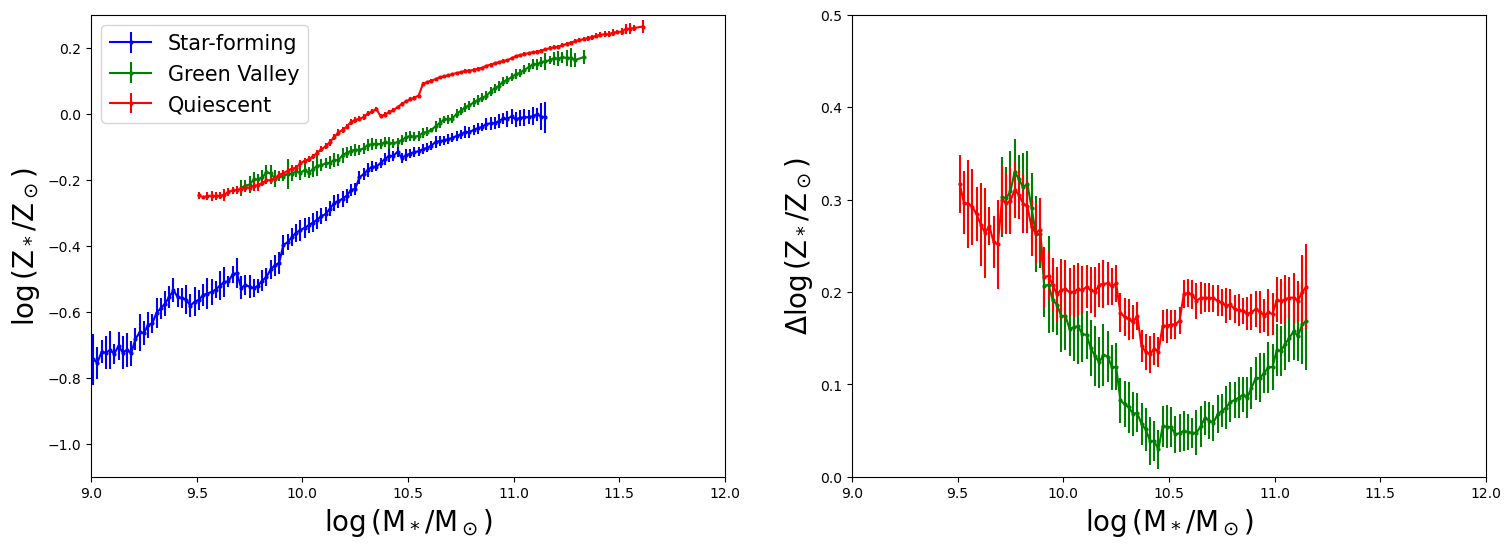

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
ax1, ax2 = axes.flatten()

# Post Processing: Selecte range of m_star
m_th_sf, m_th_gv, m_th_q = 9, 9.7, 9.5
m_mid_sf_ave, z_mid_sf_ave, z_mid_err_sf_ave = m_mid_sf_ave[m_mid_sf_ave >= m_th_sf], z_mid_sf_ave[m_mid_sf_ave >= m_th_sf], z_mid_err_sf_ave[m_mid_sf_ave >= m_th_sf]
m_mid_gv_ave, z_mid_gv_ave, z_mid_err_gv_ave = m_mid_gv_ave[m_mid_gv_ave >= m_th_gv], z_mid_gv_ave[m_mid_gv_ave >= m_th_gv], z_mid_err_gv_ave[m_mid_gv_ave >= m_th_gv]
m_mid_q_ave, z_mid_q_ave, z_mid_err_q_ave = m_mid_q_ave[m_mid_q_ave >= m_th_q], z_mid_q_ave[m_mid_q_ave >= m_th_q], z_mid_err_q_ave[m_mid_q_ave >= m_th_q]

ax1.errorbar(m_mid_sf_ave, z_mid_sf_ave, yerr=z_mid_err_sf_ave, fmt='o', color='blue', label='Star-forming', ms=2, ls='-')
ax1.errorbar(m_mid_gv_ave, z_mid_gv_ave, yerr=z_mid_err_gv_ave, fmt='o', color='green', label='Green Valley', ms=2, ls='-')
ax1.errorbar(m_mid_q_ave, z_mid_q_ave, yerr=z_mid_err_q_ave, fmt='o', color='red', label='Quiescent', ms=2, ls='-')
ax1.legend(loc='best', fontsize=15)
m_mid_sf_gv, ind_gv_sf, ind_sf_gv = np.intersect1d(m_mid_sf_ave, m_mid_gv_ave, return_indices = True, assume_unique = True)
ax2.errorbar(m_mid_sf_gv, z_mid_gv_ave[ind_sf_gv] - z_mid_sf_ave[ind_gv_sf],
                yerr=np.sqrt(z_mid_err_sf_ave[ind_gv_sf]**2 + z_mid_err_gv_ave[ind_sf_gv]**2),
                fmt='o', color='green', label='Green Valley - Star-forming', ms=2, ls='-')
m_mid_sf_q, ind_q_sf, ind_sf_q = np.intersect1d(m_mid_sf_ave, m_mid_q_ave, return_indices = True, assume_unique = True)
ax2.errorbar(m_mid_sf_q, z_mid_q_ave[ind_sf_q] - z_mid_sf_ave[ind_q_sf],
                yerr=np.sqrt(z_mid_err_sf_ave[ind_q_sf]**2 + z_mid_err_q_ave[ind_sf_q]**2),
                fmt='o', color='red', label='Quiescent - Star-forming', ms=2, ls='-')
                
for ax in [ax1, ax2]:
    ax.set_xlabel(r'$\log \rm (M_* / M_\odot)$', fontsize=20)
    ax.set_xlim(9., 12)
ax1.set_ylim(-1.1, 0.3)
ax2.set_ylim(0., 0.5)
ax1.set_ylabel(r'$\log \rm (Z_*/Z_\odot)$', fontsize=20)
ax2.set_ylabel(r'$\Delta \log \rm (Z_*/Z_\odot)$', fontsize=20)

In [42]:
sig_num = 30
m_mid_sf, age_mid_sf, age_mid_err_sf = prop_bin(
    y_prop = sdss_sf_df.mw_age_gyr.values, x_prop = sdss_sf_df.log_m_star.values, x_edges = m_star_edges,sig_num = sig_num)
m_mid_sf_ave, age_mid_sf_ave, age_mid_err_sf_ave = moving_average(
    x_prop = m_mid_sf, y_prop = age_mid_sf, y_err = age_mid_err_sf, ave_step = 10)
m_mid_gv, age_mid_gv, age_mid_err_gv = prop_bin(
    y_prop = sdss_gv_df.mw_age_gyr.values, x_prop = sdss_gv_df.log_m_star.values, x_edges = m_star_edges,sig_num = sig_num)
m_mid_gv_ave, age_mid_gv_ave, age_mid_err_gv_ave = moving_average(
    x_prop = m_mid_gv, y_prop = age_mid_gv, y_err = age_mid_err_gv, ave_step = 10)
m_mid_q, age_mid_q, age_mid_err_q = prop_bin(
    y_prop = sdss_q_df.mw_age_gyr.values, x_prop = sdss_q_df.log_m_star.values, x_edges = m_star_edges,sig_num = sig_num)
m_mid_q_ave, age_mid_q_ave, age_mid_err_q_ave = moving_average(
    x_prop = m_mid_q, y_prop = age_mid_q, y_err = age_mid_err_q, ave_step = 10)

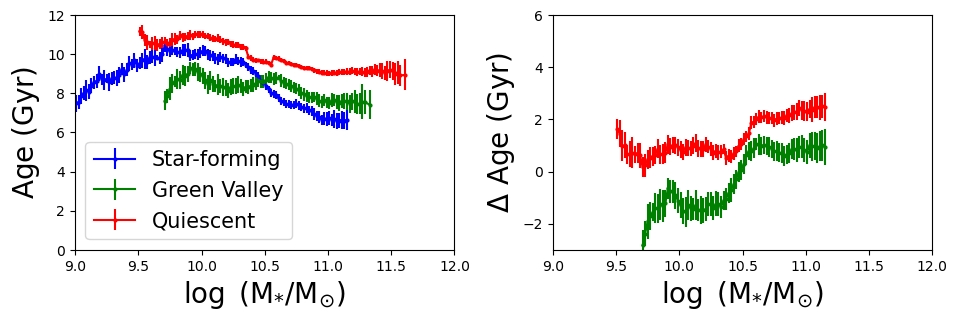

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(6/0.62, 6))
ax1, ax2 = axes.flatten()

# Post Processing: Selecte range of m_star
m_th_sf, m_th_gv, m_th_q = 9, 9.7, 9.5
m_mid_sf_ave, age_mid_sf_ave, age_mid_err_sf_ave = m_mid_sf_ave[m_mid_sf_ave > m_th_sf], age_mid_sf_ave[m_mid_sf_ave > m_th_sf], age_mid_err_sf_ave[m_mid_sf_ave > m_th_sf]
m_mid_gv_ave, age_mid_gv_ave, age_mid_err_gv_ave = m_mid_gv_ave[m_mid_gv_ave > m_th_gv], age_mid_gv_ave[m_mid_gv_ave > m_th_gv], age_mid_err_gv_ave[m_mid_gv_ave > m_th_gv]
m_mid_q_ave, age_mid_q_ave, age_mid_err_q_ave = m_mid_q_ave[m_mid_q_ave > m_th_q], age_mid_q_ave[m_mid_q_ave > m_th_q], age_mid_err_q_ave[m_mid_q_ave > m_th_q]

ax1.errorbar(m_mid_sf_ave, age_mid_sf_ave, yerr=age_mid_err_sf_ave, fmt='o', color='blue', label='Star-forming', ms=2, ls='-')
ax1.errorbar(m_mid_gv_ave, age_mid_gv_ave, yerr=age_mid_err_gv_ave, fmt='o', color='green', label='Green Valley', ms=2, ls='-')
ax1.errorbar(m_mid_q_ave, age_mid_q_ave, yerr=age_mid_err_q_ave, fmt='o', color='red', label='Quiescent', ms=2, ls='-')
ax1.legend(loc='best', fontsize=15)

m_mid_sf_gv, ind_gv_sf, ind_sf_gv = np.intersect1d(m_mid_sf_ave, m_mid_gv_ave, return_indices = True, assume_unique = True)
ax2.errorbar(m_mid_sf_gv, age_mid_gv_ave[ind_sf_gv] - age_mid_sf_ave[ind_gv_sf], yerr=np.sqrt(age_mid_err_gv_ave[ind_sf_gv]**2 + age_mid_err_sf_ave[ind_gv_sf]**2), fmt='o', color='g', ms=2, ls='-', label='Green Valley - Star-forming')
m_mid_sf_q, ind_q_sf, ind_sf_q = np.intersect1d(m_mid_sf_ave, m_mid_q_ave, return_indices = True, assume_unique = True)
ax2.errorbar(m_mid_sf_q, age_mid_q_ave[ind_sf_q] - age_mid_sf_ave[ind_q_sf], yerr=np.sqrt(age_mid_err_q_ave[ind_sf_q]**2 + age_mid_err_sf_ave[ind_q_sf]**2), fmt='o', color='r', ms=2, ls='-', label='Quiescent - Star-forming')

for ax in [ax1, ax2]:
    ax.set_box_aspect(0.618)
    ax.set_xlabel(r'$\log\ \rm (M_{*}/M_{\odot})$', fontsize=20)
    ax.set_xlim(9., 12.)
ax1.set_ylim(0., 12.)
ax2.set_ylim(-3, 6)
ax1.set_ylabel(r'$\rm Age\ (Gyr)$', fontsize=20)
ax2.set_ylabel(r'$\Delta\ \rm Age\ (Gyr)$', fontsize=20)
fig.tight_layout()

In [147]:
sdss_sf_df[sdss_sf_df.log_m_star.between(9.5,10)].age_star_gyr.describe()

count    2209.000000
mean        9.569266
std         3.144114
min         0.131461
25%         7.278362
50%        10.077149
75%        12.076282
max        14.975026
Name: age_star_gyr, dtype: float64